In [ ]:
#!pip install frc3223-azurite
#!pip install pynetworktables==2017.0.8
#!pip install pyfrc==2017.1.5

In [3]:
import numpy
import ctre

from hal_impl.data import hal_data
from matplotlib import pyplot as plt
from elevator import ElevatorSimulation
from frc3223_azurite import motors
from frc3223_azurite.conversions import *
from frc3223_azurite.pidcontroller import NoThreadingPIDController as PIDController
from matplotlib import animation, rc
from IPython.display import HTML
import matplotlib

def plot_position(sim, ylim=None):
    plt.plot(sim.ts, sim.xs)
    if ylim is None:
        ylim = (-sim.max_height_m * 0.1, sim.max_height_m * 1.1)
    plt.ylim(*ylim)
    plt.xlabel('time (s)')
    plt.ylabel('position (m)')
    plt.show()
    
def plot_velocity(sim):
    m2ft = numpy.vectorize(lambda mps: mps / sim.sprocket_radius_m)
    plt.plot(sim.ts, m2ft(sim.vs))
    #plt.ylim(-10, 10)
    plt.xlabel('time (s)')
    plt.ylabel('velocity (rad/s)')
    plt.show()

def plot_current(sim, invert=False):
    plt.plot(sim.ts, (-1 if invert else 1) * sim.currents)
    plt.ylim(-sim.motor_system.motor.stall_current * 0.1, 15)
    plt.xlabel('time (s)')
    plt.ylabel('current (A)')
    plt.show()
    
def plot_voltage(sim, invert=False):
    plt.plot(sim.ts, (-1 if invert else 1) * sim.voltages)
    plt.ylim(0, 13)
    plt.xlabel('time (s)')
    plt.ylabel('voltage (V)')
    plt.show()

width = inch_to_meter(4)
stage_x = numpy.array([0, 0, width, width, 0])
_stage_y = numpy.array([0, 1, 1, 0, 0])


def animate_lift(sim, frame_interval_ms=50, speed_factor=1):
    assert matplotlib.rcParams['animation.writer'] in matplotlib.animation.writers.list(), 'choose an available writer!'
    fig, ax = plt.subplots()
    stage_y = _stage_y * sim.max_height_m
    base_stage, stage_1, stage_2, carriage = plots = [ax.plot(stage_x, stage_y)[0] for i in range(4)]
    plt.ylim(0, (len(plots) * 2 + 0.1) * sim.max_height_m)
    dt = sim.ts[1]-sim.ts[0]
    n = int(frame_interval_ms / 1000. / dt) # number of data points to skip
    L = len(sim.ts) // n # number of data points sampled at 20 ms
    print (n, L, len(sim.ts))
    def init():
        return (line,)
    def animate(j): 
        i = j * n
        plots[1].set_ydata(stage_y + sim.xs[i])
        plots[2].set_ydata(stage_y + 2 * sim.xs[i])
        plots[3].set_ydata(stage_y * 0.3 + 3 * sim.xs[i])

        return plots


    anim = animation.FuncAnimation(fig, animate, frames=L, interval=frame_interval_ms / speed_factor, blit=True)
    return anim


def animate_climb(sim, frame_interval_ms=50, speed_factor=1):
    assert matplotlib.rcParams['animation.writer'] in matplotlib.animation.writers.list(), 'choose an available writer!'
    fig, ax = plt.subplots()
    stage_y = _stage_y * sim.max_height_m
    base_stage, stage_1, stage_2, carriage = plots = [
        ax.plot(stage_x, stage_y + i * sim.max_height_m)[0] for i in range(4)]
    plt.ylim(0, (len(plots) * 2 + 0.1) * sim.max_height_m)
    dt = sim.ts[1]-sim.ts[0]
    n = int(frame_interval_ms / 1000. / dt) # number of data points to skip
    L = len(sim.ts) // n # number of data points sampled at 20 ms
    print (n, L, len(sim.ts))
    def init():
        return (line,)
    def animate(j): 
        i = j * n
        plots[0].set_ydata(stage_y + sim.xs[i])
        plots[2].set_ydata(stage_y + 2 * sim.max_height_m - sim.xs[i])
        plots[3].set_ydata(stage_y * 0.3 + 3 * sim.max_height_m - 2 * sim.xs[i])

        return plots


    anim = animation.FuncAnimation(fig, animate, frames=L, interval=frame_interval_ms / speed_factor, blit=True)
    return anim


In [44]:
def init(state):
    import wpilib
    state.timer = wpilib.Timer()
    state.timer.start()
    state.motor.set(0.0)
    ctre.WPI_TalonSRX.Notifier = None
    '''
    talon = ctre.WPI_TalonSRX(1)
    
    talon.selectProfileSlot(0, 0)
    talon.configSelectedFeedbackSensor(talon.FeedbackDevice.QuadEncoder, 0, 0)
    talon.configMotionCruiseVelocity(int(3 * 4096 * 0.1), 0) # 1 rps
    talon.configMotionAcceleration(int(6 * 4096 * 0.1), 0) # 2 rps^2
    talon.configAllowableClosedloopError(0, 50, 0)
    talon.config_kP(0, 0.5, 0)
    talon.config_kI(0, .00, 0)
    talon.config_kD(0, 10, 0)
    state.talon = talon
    state.t1 = False
    '''
    #state.talon.set(ctre.ControlMode.MotionMagic, int(inch_to_meter(30) / sim.sprocket_radius_m * 4096 / (2 * math.pi)))
    
def pid_periodic(state):
    enc_pos = int(state.x / sim.sprocket_radius_m * 4096 / (2 * math.pi))
    enc_vel = int(state.velocity_mps / sim.sprocket_radius_m * 4096 / (2 * math.pi))
    hal_data['CAN'][1]['quad_position'] = enc_pos
    hal_data['CAN'][1]['quad_velocity'] = enc_vel
    #state.talon._calculate_1ms()
    #state.motor.set(state.talon.hal_data['value'])
def periodic(state):
    state.motor.set(1)
    return
    if not state.t1 and state.timer.get() >= 4:
        state.t1 = True
        state.talon.set(ctre.ControlMode.MotionMagic, int(inch_to_meter(10) / sim.sprocket_radius_m * 4096 / (2 * math.pi)))
    pass


sim = ElevatorSimulation(
    starting_position_m=inch_to_meter(10),
    max_height_m=inch_to_meter(72),
    sprocket_radius_m=inch_to_meter(2.12),
    robot_mass_kg=lbs_to_kg(154),
    stage1_mass_kg=lbs_to_kg(16),
    stage2_mass_kg=lbs_to_kg(0.0),
    stage3_mass_kg=lbs_to_kg(0.0),
    stage1_counterweighting_n=lbs_to_N(.0),
    stage2_counterweighting_n=lbs_to_N(0.0),
    friction_force_N=225,
    pulls_down = False,
    init=init,
    battery_voltage=12.3,
    periodic=periodic,
    #pid_periodic=pid_periodic,
    pid_sample_rate_s=0.001,
    gearbox_efficiency=0.55,
    motor_system=motors.MotorSystem(motor=motors.bag, motor_count=4, gearing_ratio=50),
    dt_s=0.0001,
)

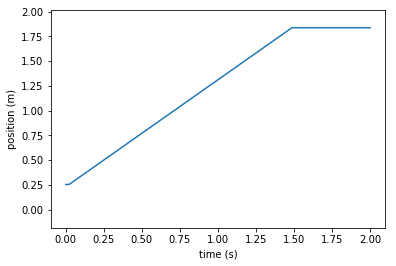

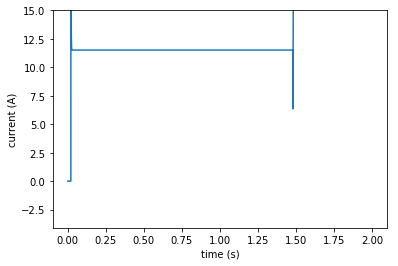

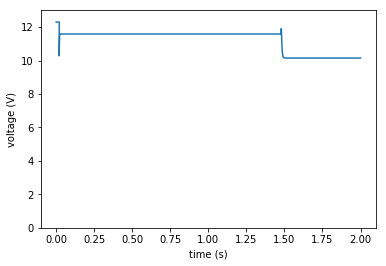

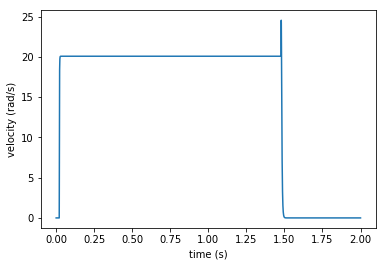

20.076784333


In [42]:
sim.run_lift_sim(timeout=2)
#sim.write_csv("wat.csv")
plot_position(sim)
plot_current(sim)
plot_voltage(sim)
plot_velocity(sim)
print (numpy.median(sim.vs) /sim.sprocket_radius_m)

In [52]:
HTML(animate_lift(sim).to_html5_video())

250 241 60497


4.5124852888833376


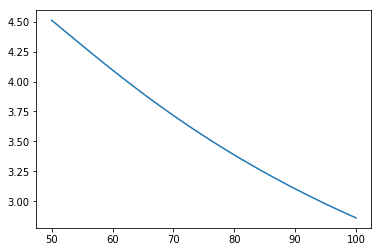

In [46]:
def elv_speed_ftps(ng, load):
    radius = inch_to_meter(2.12)
    motor_torque = load * radius / ng
    #print(motors.bag.current_at_torque(motor_torque))
    rotmotor = motors._775pro.speed_at_torque(motor_torque)
    vel = meter_to_feet(rotmotor * radius / ng)
    return vel

a = elv_speed_ftps(50, 230)
print(a)
ngs = numpy.linspace(50, 100)
speed_func = numpy.vectorize(lambda ng: elv_speed_ftps(ng, 230))
speeds = speed_func(ngs)
plt.plot(ngs, speeds)
plt.show()

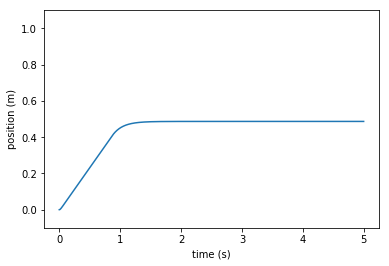

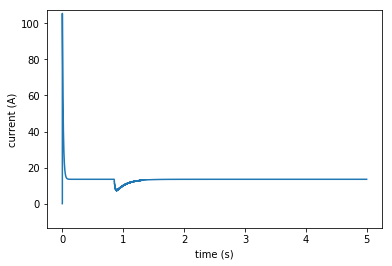

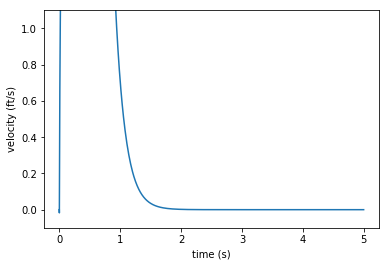

In [54]:
sim.run_climb_sim(timeout=5)
plot_position(sim)
plot_current(sim)
plot_velocity(sim)

In [31]:
#HTML(animate_climb(sim).to_html5_video())
50 * .25 / inch_to_meter(2.12)

232.1348982320606

In [9]:
import wpilib

In [2]:
5.12 * 12 / 2.12


28.981132075471695

In [11]:
inch_to_meter(2.12)

0.053848

In [12]:
1466 / 50.

29.32